In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

/home/gfernandez/miniforge3/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/media/scratrch_data/gfernandez/STEProids/nbs/src/learner_nested_tensors_pytorch.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
/home/gfernandez/miniforge3/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/media/scratrch_data/gfernandez/STEProids/nbs/src/learner_pad_mask_pytorch.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [ ]:
#| export

def save_plot(fig, fname, fpath="../../../data/vis/", save=1, x=None, y=None):
    """Optionally saves (1) png, (2) svg, and (3) data to reproduce the plot."""
    if save >= 1:
        fig.savefig(fpath+fname+'.png')
        if save >=2: 
            fig.savefig(fpath+fname+'.svg')
            if save >=3:# TODO generalize to dict of arrays
                assert x is not None
                assert y is not None
                np.savez_compressed(fpath+fname, x=x, y=y)

# Data management and generation

In [ ]:
#| default_exp data

In [ ]:
#| export

from pathlib import Path
from zipfile import ZipFile
from urllib.request import urlretrieve

import re, shutil, numpy as np, pandas as pd
from tqdm.auto import tqdm, trange
from fastai.vision.all import *
from torch.utils.data import Dataset#, DataLoader

# Public challenge data

The [2nd AnDi Challenge](https://codalab.lisn.upsaclay.fr/competitions/16618) offers a starting kit and a public training data set.

In [ ]:
#| export

def get_challenge_data(url, data_path):
    """Download the available public data from the url and save it in the desired path."""
    data_path = Path(data_path)
    data_path.mkdir(exist_ok=True)
    temp = (data_path.parent/"temp").with_suffix(".zip")
    urlretrieve(url, temp)
    # TODO download progress bar
    with ZipFile(temp, "r") as zipped_file:
        zipped_file.extractall(data_path)
    temp.unlink()

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw")
data_path.exists()

True

In [ ]:
url_starting_kit = "https://codalab.lisn.upsaclay.fr/my/datasets/download/338ee871-3adf-401b-add8-abe82579c58b"

In [ ]:
get_challenge_data(url_starting_kit, data_path/"starting_kit")

In [ ]:
url_challenge = "https://codalab.lisn.upsaclay.fr/my/datasets/download/1086ae21-a81b-47cd-9899-089d2527bfc1"

In [ ]:
get_challenge_data(url_challenge, data_path/"challenge")

In [ ]:
data_path

Path('/media/scratrch_data/nanoninjas/data/raw')

In [ ]:
!ls $data_path/challenge/track_2

exp_0  exp_10  exp_2  exp_4  exp_6  exp_8
exp_1  exp_11  exp_3  exp_5  exp_7  exp_9


In [ ]:
!ls $data_path/challenge/track_2/exp_0

trajs_fov_0.csv   trajs_fov_17.csv  trajs_fov_24.csv  trajs_fov_4.csv
trajs_fov_10.csv  trajs_fov_18.csv  trajs_fov_25.csv  trajs_fov_5.csv
trajs_fov_11.csv  trajs_fov_19.csv  trajs_fov_26.csv  trajs_fov_6.csv
trajs_fov_12.csv  trajs_fov_1.csv   trajs_fov_27.csv  trajs_fov_7.csv
trajs_fov_13.csv  trajs_fov_20.csv  trajs_fov_28.csv  trajs_fov_8.csv
trajs_fov_14.csv  trajs_fov_21.csv  trajs_fov_29.csv  trajs_fov_9.csv
trajs_fov_15.csv  trajs_fov_22.csv  trajs_fov_2.csv
trajs_fov_16.csv  trajs_fov_23.csv  trajs_fov_3.csv


# Data set properties

Given a data set, it is important to know the meta statistics, such as the number of FOVs per experiment, the number of trajectories for every FOV, the trajectory lenghts, etc.

In [ ]:
#| export

def dataset_statistics(data_path, track="2"):
    """Extract meaningful statistics from the data set in the given path."""
    stats = {"fovs_per_exp": [], "trajs_per_fov": [], "traj_lengths": [],
             "models": [], "states_per_fov": [],
             "ks": [], "alphas": [], "states": [], "cps": []}
    try:
        metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
        num_FOVs = metadata.shape[0]
    except:
        num_FOVs = None
        
    for exp_path in tqdm((data_path/f"track_{track}").iterdir(), total=num_FOVs):
        if not exp_path.is_dir():    continue

        traj_files       = sorted([f for f in exp_path.iterdir() if re.search(r"trajs_fov_\d*.csv",     f.name)])
        ens_label_files  = sorted([f for f in exp_path.iterdir() if re.search(r"ens_labs_fov_\d*.txt",  f.name)])
        traj_label_files = sorted([f for f in exp_path.iterdir() if re.search(r"traj_labs_fov_\d*.txt", f.name)])

        stats["fovs_per_exp"].append(len(traj_files))
        
        for fov_file in traj_files:
            df = pd.read_csv(fov_file)
            traj_idxes = df.traj_idx.unique()
            stats["trajs_per_fov"].append(len(traj_idxes))
            stats["traj_lengths"].append([(idx == df.traj_idx).sum() for idx in traj_idxes])

        for file in ens_label_files:
            with open(file, "r") as f:
                info = f.readline()
            model, n_states = [re.findall(r": (\w*|\d*)", s)[0] for s in info.split(";")]
            stats["models"].append(model)
            stats["states_per_fov"].append(int(n_states))
        
        for file in traj_label_files:
            with open(file, "r") as f:
                traj_info = f.readlines()

            fov_ks, fov_alphas, fov_states, fov_cps = [], [], [], []
            for info in traj_info:
                ks, alphas, states, cps = _parse_trajectory_info(info)
                fov_ks.append(ks)
                fov_alphas.append(alphas)
                fov_states.append(states)
                fov_cps.append(cps)
            stats["ks"].append(fov_ks)
            stats["alphas"].append(fov_alphas)
            stats["states"].append(fov_states)
            stats["cps"].append(fov_cps)
            
    return stats

def _parse_trajectory_info(info):
    """Extract the trajectory information from the labels. 
    The file format is:
    traj_idx,K_0,alpha_0,state_0,cp_0,...,state_n,traj_len"""
    ks, alphas, states, cps = [], [], [], []
    split_info = re.findall(r"\d*,(.*)\n$", info)[0].split(",")
    ks.extend(    [float(f)  for f in split_info[::4]])
    alphas.extend([float(f)  for f in split_info[1::4]])
    states.extend([int(i[0]) for i in split_info[2::4]])
    cps.extend(   [int(i)    for i in split_info[3::4]])
    return ks, alphas, states, cps

In [ ]:
data_path

PosixPath('/media/scratrch_data/nanoninjas/data/raw')

In [ ]:
!ls $data_path

baby	   medium_15  medium_22  medium_3   medium_37  medium_44  medium_7
medium_0   medium_16  medium_23  medium_30  medium_38  medium_45  medium_8
medium_1   medium_17  medium_24  medium_31  medium_39  medium_46  medium_9
medium_10  medium_18  medium_25  medium_32  medium_4   medium_47  public_data
medium_11  medium_19  medium_26  medium_33  medium_40  medium_48  starting_kit
medium_12  medium_2   medium_27  medium_34  medium_41  medium_49  test
medium_13  medium_20  medium_28  medium_35  medium_42  medium_5   train
medium_14  medium_21  medium_29  medium_36  medium_43  medium_6


In [ ]:
path_ds = data_path/"starting_kit" #'medium_49'#'baby'#

stats = dataset_statistics(path_ds)

0it [00:00, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
from functools import partial
plt.hist = partial(plt.hist, histtype='step', bins=100)

In [ ]:
path_ds.name

'starting_kit'

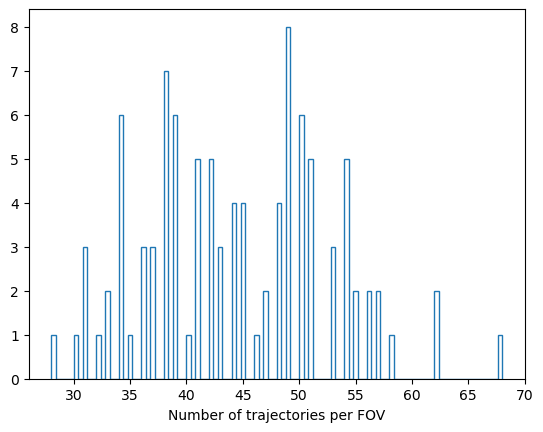

In [ ]:
plt.hist(stats["trajs_per_fov"])
plt.xlabel("Number of trajectories per FOV");
save_plot(plt.gcf(), 'num_trajs_per_FOV_on_'+path_ds.name)

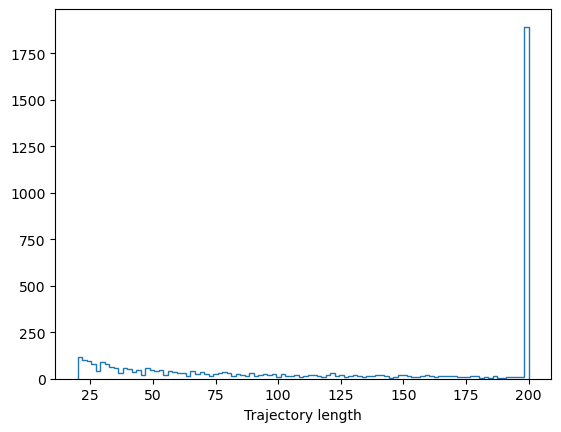

In [ ]:
plt.hist([t for tls in stats["traj_lengths"] for t in tls])
plt.xlabel("Trajectory length");
save_plot(plt.gcf(), 'trajs_len_on_'+path_ds.name)

In [ ]:
np.unique([s for st in stats['traj_lengths'] for s in st ])

array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
       189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 20

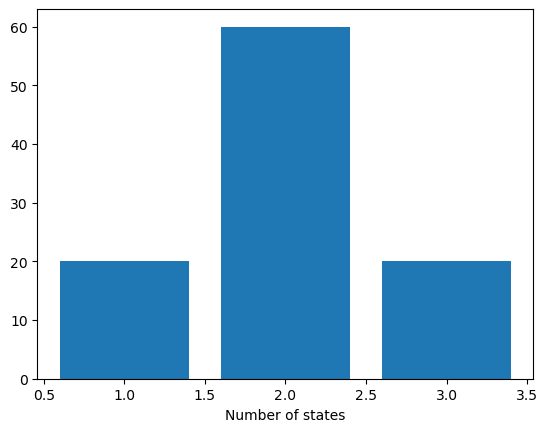

In [ ]:
n_states, counts = np.unique(stats["states_per_fov"], return_counts=True)
plt.bar(n_states, counts)
plt.xlabel("Number of states");
save_plot(plt.gcf(), 'num_states_per_FOV_on_'+path_ds.name)

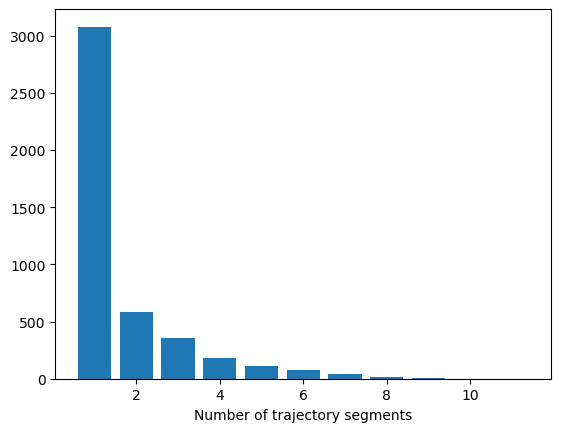

In [ ]:
n_traj_segments = [len(traj_cps) for fov_cps in stats["cps"] for traj_cps in fov_cps]
n_segments, counts = np.unique(n_traj_segments, return_counts=True)

plt.bar(n_segments, counts)
plt.xlabel("Number of trajectory segments");

save_plot(plt.gcf(), 'num_segments_in_traj_on_'+path_ds.name)

In [ ]:
ks = [np.log10(k) if k > 0 else -12 for fov_ks in stats["ks"] for traj_ks in fov_ks for k in traj_ks]

In [ ]:
min(ks), max(ks)

(-12, 0.14810136146205077)

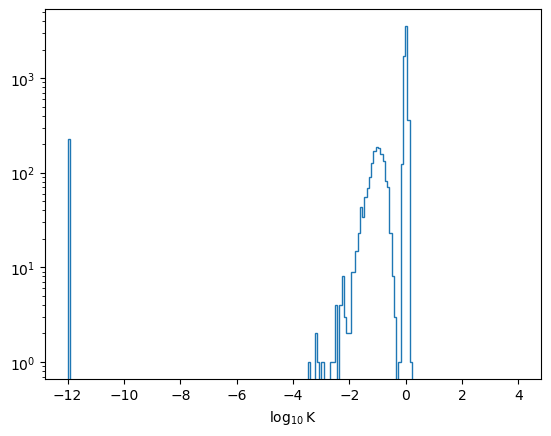

In [ ]:
plt.hist(ks, bins=(np.linspace(-12, 4, 200))) # ks for segments
plt.yscale("log")
plt.xlabel(r"$\log_{10}$K");

save_plot(plt.gcf(), 'K_distro_on_'+path_ds.name)

In [ ]:
27*50

1350

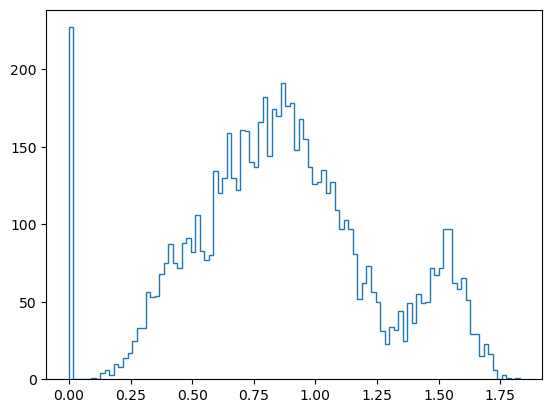

In [ ]:
alphas = [a for fov_states in stats["alphas"] for traj_states in fov_states for a in traj_states]
plt.hist(np.array(alphas).reshape(-1));

save_plot(plt.gcf(), 'alpha_distro_on_'+path_ds.name)

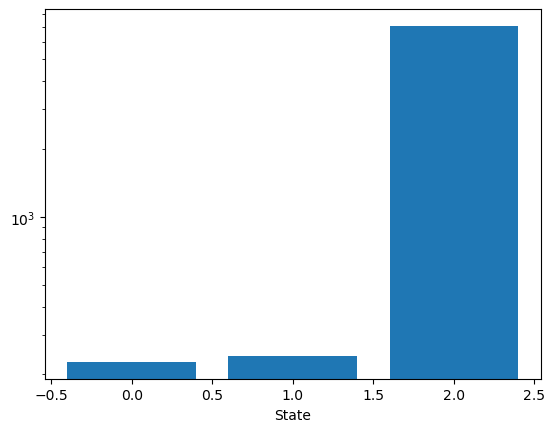

In [ ]:
states = [s for fov_states in stats["states"] for traj_states in fov_states for s in traj_states]

unique_states, counts = np.unique(states, return_counts=True)

plt.bar(unique_states, counts, log=True)
plt.xlabel("State");

save_plot(plt.gcf(), 'diff_state_on_'+path_ds.name)

In [ ]:
# cps per length?
stats['cps']

In [ ]:
stats['traj_lengths']

[[600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600,
  600],
 [74,
  600,
  122,
  577,
  236,
  96,
  175,
  230,
  164,
  525,
  212,
  185,
  393,
  81,
  600,
  600,
  200,
  32,
  273,
  326,
  292,
  33,
  323,
  23,
  33,
  199,
  124,
  178,
  440,
  325,
  156,
  600,
  600,
  152,
  302,
  600,
  600,
  178,
  29,
  360,
  88,
  305,
  402,
  600,
  579,
  143,
  413,
  514,
  408,
  67,
  600,
  29,
  156,
  600,
  600,
  356,
  470,
  600,
  600,
  74,
  600,
  600,
  600,
  227,
  600,
  600,
  600,
  218,
  102,
  549,
  545,
  580,
  600,
  173,
  493,
  24,
  194,
  566,
  208,
  600,
  405,
  20,
  429,
  44,
  249,
  28,
  35,
  136,
 

# Data set generation

The data is organized in experiments, each of which has different fixed properties.
In every experiment, there are several FOVs, all containing trajectories that follow the underlying model dictated by the experiment.
We consider 5 different models:
- **1 - Single state**: this model is characterized by an homogeneous behaviour with a single diffusive state characterized by a diffusion coefficient and alpha. These can either be a fixed value or sampled fom a normal distribution with a given mean and variance.
- **2 - Multi-state**: this model features various diffusive states. The changes happen at random and they are characterized by the transition matrix `M`, which defines the probability to go from one state to another.
- **3 - Immobile traps**: two-state diffusion process where the particles can be completely immobilized whenever they land within a radius `r` from a trap. Only the properties for the free diffusion need to be specified, and the binding and unbinding probabilities are given by `Pb` and `Pu`, respectively.
- **4 - Dimerization**: two-state diffusion process where the particles have a probability to bind to each other whenever they are within a distance `2r`. The binding and unbinding probabilities are given by `Pb` and `Pu`, respectively.
- **5 - Confinement**: two-state diffusion process where particles can enter compartments of radius `r`, where the diffusion properties change. The particles seamlessly enter into the compartments, but they may struggle to exit depending on the membrane's transmittance `trans`.

In the cases of immobile traps and confinement, we can pre-define the position of the special areas beforehand.

We can see the different available models with:

In [ ]:
from andi_datasets.datasets_phenom import datasets_phenom

In [ ]:
datasets_phenom().avail_models_name

['single_state',
 'multi_state',
 'immobile_traps',
 'dimerization',
 'confinement']

The data sets are created from a list of dictionaries. Every dictionary contains the details for the underlying model the trajectories will be following. The default values for every model can be accessed in `_get_dic_andi2(model)`.

In [ ]:
#| export

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_challenge import challenge_phenom_dataset, _get_dic_andi2

In [ ]:
#| export

TRAJ_LEN = 600
N_TRAJ_FOV = 200

_info = models_phenom()
# _range_D = np.array(_info.bound_D)
# _range_D_log = np.log10(_range_D)
_range_D_log = np.array([-7, 2])
_range_alpha = np.array(_info.bound_alpha)
_MIN_D_DIST, _MAX_D_DIST = 0.1, 3  # In log space
_MIN_ALPHA_DIST = 0.1

def create_track_2_dataset(path, n_exps_per_model):
    """Create a data set for track 2 (trajetories). Every experiment is different and has a unique FOV."""
    dicts = []
    metadata = []
    exp_gen = ExperimentGenerator()
    for model in np.arange(5)+1:
        for _ in range(n_exps_per_model):
            exp_dic = exp_gen(model)
            dicts.append(exp_dic)
            metadata.append(_metadata_from_dic(exp_dic))

    _ = challenge_phenom_dataset(save_data = True, # If to save the files
                                 dics = dicts, # Dictionaries with the info of each experiment (and FOV in this case)
                                 path = path, # Parent folder where to save all data
                                 return_timestep_labs = True,
                                 get_video = False, 
                                 num_fovs = 1, # Number of FOVs                                                                
                                 files_reorg = True, # We reorganize the folders for challenge structure
                                 path_reorg = path/'ref', # Folder inside PATH where to reorganized
                                 save_labels_reorg = True, # The labels for the two tasks will also be saved in the reorganization                                                                 
                                 delete_raw = True # If deleting the original raw dataset
                                 )

    shutil.move(path/"ref/track_2", path/"track_2")
    shutil.rmtree(path/"ref")
    pd.DataFrame.from_records(metadata).to_csv(path/"track_2/metadata.csv")

class ExperimentGenerator:
    """Experiment condition generator."""

    def __call__(self, model):
        """Return a dictionary with random experimental conditions for the given model."""
        dic = _get_dic_andi2(model)
        dic["N"] = N_TRAJ_FOV
        dic["T"] = TRAJ_LEN
        return self._fill_dic(dic)

    def _fill_dic(self, dic):
        dic_gen = getattr(self, f"_random_dic_{dic['model']}")
        return dic_gen(dic)

    @staticmethod
    def _random_dic_single_state(dic):
        "Provide random parameters for the single state model."
        D = 10 ** np.random.uniform(*_range_D_log)
        D_std = D / 10 ** np.random.uniform(0.5, 2.5)  # Between 3 to 300 times smaller
        alpha = np.random.uniform(*_range_alpha)
        alpha_std = 10 ** np.random.uniform(-3, -1)  # Between 0.001 and 0.1

        dic["Ds"] = [D, D_std]
        dic["alphas"] = [alpha, alpha_std]
        return dic
        
    @staticmethod
    def _random_dic_multi_state(dic):
        "Provide random parameters for the multi state model."
        n_states = np.random.randint(2, 5)  # Between 2 to 4 states

        Ds = np.zeros((n_states, 2))
        Ds[:, 0] = 10 ** _sample_not_far_not_close(_range_D_log, _MIN_D_DIST, _MAX_D_DIST, n_states)
        Ds[:, 1] = Ds[:, 0] / 10 ** np.random.uniform(0.5, 2.5)  # Between 3 to 300 times smaller

        alphas = np.zeros((n_states, 2))
        alphas[:, 0] = _sample_not_far_not_close(_range_alpha, _MIN_ALPHA_DIST, 2, n_states)
        alphas[:, 1] = 10 ** np.random.uniform(-3, -1, n_states)  # Between 0.001 and 0.1

        trans_prob = 0.01  # Same transition probability for all states
        M = np.ones((n_states, n_states)) * trans_prob 
        np.fill_diagonal(M, 1 - trans_prob * (n_states - 1))

        dic["Ds"] = Ds
        dic["alphas"] = alphas
        dic["M"] = M
        return dic

    def _random_dic_immobile_traps(self, dic):
        "Provide random parameters for the immobile traps model."
        dic = self._random_dic_single_state(dic)  # Sets D and alpha for free state

        dic["Pu"] = 0.01  # Default 0.01
        dic["Pb"] = np.random.uniform(0.8, 1.)  # Default 1.
        dic["Nt"] = np.random.randint(50, 600)  # Default 300
        dic["r"] = 10 ** np.random.uniform(-1, 0.3) # From 0.1 to 2 (default 0.4)
        return dic

    @staticmethod
    def _random_dic_dimerization(dic):
        "Provide random parameters for the dimerization model."
        n_states = 2  # Free and bound states

        Ds = np.zeros((n_states, 2))
        Ds[:, 0] = 10 ** _sample_not_far_not_close(_range_D_log, _MIN_D_DIST, _MAX_D_DIST, n_states)
        Ds[:, 1] = Ds[:, 0] / 10 ** np.random.uniform(0.5, 2.5)  # Between 3 to 300 times smaller

        alphas = np.zeros((n_states, 2))
        alphas[:, 0] = _sample_not_far_not_close(_range_alpha, _MIN_ALPHA_DIST, np.infty, n_states)
        alphas[:, 1] = 10 ** np.random.uniform(-3, -1, n_states)  # Between 0.001 and 0.1

        dic["Ds"] = Ds
        dic["alphas"] = alphas
        dic["Pu"] = 0.01  # Default 0.01
        dic["Pb"] = np.random.uniform(0.8, 1.)  # Default 1.
        dic["r"] = 10 ** np.random.uniform(-1, 0.3) # From 0.1 to 2 (default 0.6)
        return dic
    
    @staticmethod
    def _random_dic_confinement(dic):
        "Provide random parameters for the confinement model."
        n_states = 2  # Outside and inside a compartment
        
        Ds = np.zeros((n_states, 2))
        Ds[:, 0] = 10 ** _sample_not_far_not_close(_range_D_log, _MIN_D_DIST, _MAX_D_DIST, n_states)
        Ds[:, 1] = Ds[:, 0] / 10 ** np.random.uniform(0.5, 2.5)  # Between 3 to 300 times smaller

        alphas = np.zeros((n_states, 2))
        alphas[:, 0] = _sample_not_far_not_close(_range_alpha, _MIN_ALPHA_DIST, np.infty, n_states)
        alphas[:, 1] = 10 ** np.random.uniform(-3, -1, n_states)  # Between 0.001 and 0.1

        dic["Ds"] = Ds
        dic["alphas"] = alphas
        dic["r"] = np.random.uniform(2, 20)  # Default 5
        area_fraction = np.random.uniform(0.04, 0.5)  # Nc=30: r=5 -> 0.089, r=10 -> 0.356
        dic["Nc"] = int(np.round(area_fraction * dic["L"] ** 2 / (2 * np.pi * dic["r"] ** 2)))
        dic["trans"] = np.random.uniform(0.0, 0.3)  # Default 0.1
        return dic

def _metadata_from_dic(dic):
    "Obtain the experiment metadata from its dictionary."
    Ds = np.zeros((4, 2))  # Maximum 4 states in multi-state model
    alphas = np.zeros((4, 2))

    if len(np.shape(dic["Ds"])) == 1:
        Ds[0, :] = dic["Ds"]
        alphas[0, :] = dic["alphas"]
    else:
        Ds[:dic["Ds"].shape[0]] = dic["Ds"]
        alphas[:dic["alphas"].shape[0]] = dic["alphas"]
    
    return {"model": dic["model"],
            "n_states": (Ds[:, 0] != 0).sum(),
            **{f"D{i}": D for i, D in enumerate(Ds[:, 0])},
            **{f"D{i}_std": D_std for i, D_std in enumerate(Ds[:, 1])},
            **{f"alpha{i}": a for i, a in enumerate(alphas[:, 0])},
            **{f"alpha{i}_std": a for i, a in enumerate(alphas[:, 1])}}

def _sample_not_far_not_close(val_range, min_dist, max_dist, n_samples):
    """Sample values within the given range that are all further than a minimum distance but closer
    than a maximum one within each other."""
    values = np.zeros(n_samples)
    values[0] = np.random.uniform(*val_range)

    for i in range(1, n_samples):
        val_range = _update_feasible_range(val_range, values[:i], max_dist)
        values[i] = np.random.uniform(*val_range)
        distances = _compute_distances(values[:i+1])
        while (np.abs(distances) < min_dist).any():
            values[i] = np.random.uniform(*val_range)
            distances = _compute_distances(values[:i+1])

    return values

def _update_feasible_range(val_range, values, max_dist):
    """Updates the feasible range to sample subsequent values from."""    
    val_range[0] = max(val_range[0], values.max() - max_dist)
    val_range[1] = min(val_range[1], values.min() + max_dist)

    return val_range

def _compute_distances(values):
    """Compute the relative distances between all values."""
    return (values[None] - values[:, None])[np.triu_indices(len(values), k=1)]  # scipy.special.pdist

# Data sets and data loaders

Data loaders handle the loading of the data into memory, as the name hints, in order to process.
We use PyTorch's `Dataset` and `DataLoader` classes ([see the docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)) to handle this process.

## FOVDataset

In [ ]:
#| export
import jax
import jax.numpy as jnp
def collate_fn(batch):
    "Do not attempt to stack the samples in a batch."
    batch = jax.tree_util.tree_map(jnp.array, batch)
    return list(zip(*batch))  # (trajectory batch, label batch)

class FOVDataset(Dataset):
    """FOV-centric dataset in which every sample is a full FOV."""

    def __init__(self, path, train=True, transforms=[]):
        """Save the directory containing the FOVs, the transforms, and the metadata.
        When `train=False` it disregards the labels."""
        self.path = path
        self.train = train
        self.transforms = transforms
        self.metadata = pd.read_csv(data_path/"metadata.csv", index_col=0)

    def __len__(self):
        "Return the number of FOVs in the dataset"
        return self.metadata.shape[0]
    
    def __getitem__(self, idx):
        "Load the idx-th FOV and apply the transforms."
        trajs, labels = [], []
        fov = pd.read_csv(self.path/f"exp_{idx}/trajs_fov_0.csv")
        for traj_idx in np.sort(fov.traj_idx.unique()):
            mask = fov.traj_idx == traj_idx
            traj = np.stack((fov.x[mask], fov.y[mask]), axis=1)  #  shape (length, 2)

            if self.train:
                label = np.stack([getattr(fov, label)[mask].values  # shape (length, 3)
                                   for label in ["alpha", "D", "state"]], axis=1)
            else:
                label = []

            trajs.append(traj)
            labels.append(label)

        for transform in self.transforms:
            trajs, labels = transform(trajs, labels)

        return trajs, labels

    def to_dl(self, batch_size=None, shuffle=None, collate_fn=collate_fn):
        "Transform the Dataset into a DataLoader."
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2")

In [ ]:
data = FOVDataset(data_path)
dl = data.to_dl(batch_size=3, shuffle=False)

In [ ]:
x, y = next(iter(dl))

2024-06-12 17:43:22.766126: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
len(x), len(y)

(3, 3)

In [ ]:
x[0][0].shape

(87, 2)

## Single Trajectory Dataset

In [ ]:
#| export

def create_array_dataset(data_path, track="2"):
    """Create data set from the given path."""
    # make an npz file with arrays of different trajectory length
    # separate T=600 in another file.
    lengths = np.arange(20,601)
    trajs = {str(length):[] for length in lengths}
    metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    num_FOVs = metadata.shape[0]
    for exp_path in tqdm((data_path/f"track_{track}").iterdir(), total=num_FOVs):
        if not exp_path.is_dir():    continue
        traj_paths = [f for f in exp_path.iterdir() if re.search(r"trajs_fov_\d*.csv",     f.name)]
        for fov_path in traj_paths:
            df = pd.read_csv(fov_path)
            traj_idxes = df.traj_idx.unique()
            for traj_idx in traj_idxes:
                mask = df.traj_idx == traj_idx
                # traj = np.stack([getattr(df, label)[mask].values  # shape (length, 5)
                #                  for label in ['x', 'y',"alpha", "D", "state"]], axis=1)
                traj = df[mask][['x','y',"alpha", "D", "state"]].values
                # get cps from cps_idx, alphas, Ds, states = label_continuous_to_list(label)
                # https://github.com/AnDiChallenge/andi_datasets/blob/master/andi_datasets/utils_challenge.py#L187
                cps_idx = np.argwhere((traj[:-1, 2:] != traj[1:, 2:]).sum(1) != 0).flatten()
                cps_idx = np.append(cps_idx,len(traj)-1) 
                cps = np.zeros((len(traj),1), dtype=int)
                cps[cps_idx] = 1
                traj = np.concatenate((traj,cps), axis=-1)
                trajs[str(traj.shape[0])].append(traj)
                
    # cast lists to numpy array
    for k,v in trajs.items():    trajs[k] = np.array(v, dtype=np.float32)
    num_trajs_len = np.array([v.shape[0] for v in trajs.values()])
    
    # clean empty arrays
    empty_len_idx = np.argwhere(num_trajs_len==0).squeeze()
    for idx in empty_len_idx:    del trajs[str(lengths[idx])]
    lengths       = np.delete(lengths,       empty_len_idx)
    num_trajs_len = np.delete(num_trajs_len, empty_len_idx)
    
    # save traj len=600 separated and delete
    np.savez_compressed(data_path/f"track_{track}"/'trajectories_600.npz', l600=trajs.pop(str(600)))
    np.savez_compressed(data_path/f"track_{track}"/'trajectories.npz', **trajs,
                        num_trajs_len=num_trajs_len[:-1], lengths=lengths[:-1])   
    print(f'Saved at {data_path/f"track_{track}"/"trajectories.npz"}')

In [ ]:
#| export

def create_array_dataset_np(data_path, track="2"):
    """Create data set from the given path."""
    # make an npz file with arrays of different trajectory length
    # separate T=600 in another file.
    lengths = np.arange(20,601)
    trajs = {str(length):[] for length in lengths}
    metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    num_FOVs = metadata.shape[0]
    for exp_path in tqdm((data_path/f"track_{track}").iterdir(), total=num_FOVs):
        if not exp_path.is_dir():    continue
        traj_paths = [f for f in exp_path.iterdir() if re.search(r"trajs_fov_\d*.csv",     f.name)]
        for fov_path in traj_paths:
            df = pd.read_csv(fov_path, engine='pyarrow')
            # traj_idxes = df.traj_idx.unique()
            ids = df['traj_idx'].to_numpy(dtype=int) # ids with all the occurrences
            # unique ids, ids index, and lengths
            ids_,ids_fidx, lengths_ = np.unique(ids, return_index=True, return_counts=True)
            df_np = df[['x','y',"alpha", "D", "state"]].to_numpy();
            trajs_ = [df_np[ids_fidx[i]:ids_fidx[i]+lengths_[i]] for i in ids_]
            for traj in trajs_:
                # mask = df.traj_idx == traj_idx
                # traj = np.stack([getattr(df, label)[mask].values  # shape (length, 5)
                #                  for label in ['x', 'y',"alpha", "D", "state"]], axis=1)
                # traj = df[mask][['x','y',"alpha", "D", "state"]].values
                # get cps from cps_idx, alphas, Ds, states = label_continuous_to_list(label)
                # https://github.com/AnDiChallenge/andi_datasets/blob/master/andi_datasets/utils_challenge.py#L187
                cps_idx = np.argwhere((traj[:-1, 2:] != traj[1:, 2:]).sum(1) != 0).flatten()
                cps_idx = np.append(cps_idx,len(traj)-1) 
                cps = np.zeros((len(traj),1), dtype=int)
                cps[cps_idx] = 1
                traj = np.concatenate((traj,cps), axis=-1)
                trajs[str(traj.shape[0])].append(traj)
                
    # cast lists to numpy array
    for k,v in trajs.items():    trajs[k] = np.array(v, dtype=np.float32)
    num_trajs_len = np.array([v.shape[0] for v in trajs.values()])
    
    # clean empty arrays
    empty_len_idx = np.argwhere(num_trajs_len==0).squeeze()
    for idx in empty_len_idx:    del trajs[str(lengths[idx])]
    lengths       = np.delete(lengths,       empty_len_idx)
    num_trajs_len = np.delete(num_trajs_len, empty_len_idx)
    
    # save traj len=600 separated and delete
    np.savez_compressed(data_path/f"track_{track}"/'trajectories_600.npz', l600=trajs.pop(str(600)))
    np.savez_compressed(data_path/f"track_{track}"/'trajectories.npz', **trajs,
                        num_trajs_len=num_trajs_len[:-1], lengths=lengths[:-1])   
    print(f'Saved at {data_path/f"track_{track}"/"trajectories.npz"}')

## speed up creation with numpy and pyarrow

In [ ]:
!ls $data_path/'baby/track_2/exp_0/'

ensemble_labels.txt  ens_labs_fov_0.txt  traj_labs_fov_0.txt  trajs_fov_0.csv


In [ ]:
df = pd.read_csv(data_path/'baby/track_2/exp_0/trajs_fov_0.csv',)

In [ ]:
%timeit pd.read_csv(data_path/'baby/track_2/exp_0/trajs_fov_0.csv',)

23.5 ms ± 1.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit pd.read_csv(data_path/'baby/track_2/exp_0/trajs_fov_0.csv',dtype={'traj_idx': np.int32, 'frame': np.int32, 'x': np.float32,'y': np.float32,'alpha': np.float32,'D': np.float32,'state': np.float32})

29.7 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
import pyarrow

In [ ]:
pd.__version__, pyarrow.__version__

('2.2.2', '16.1.0')

In [ ]:
df.head()

,traj_idx,frame,x,y,alpha,D,state
0,0.0,63.0,96.678400,76.536030,1.598922,1.241302,2.0
1,0.0,64.0,96.185319,76.452512,1.598922,1.241302,2.0
2,0.0,65.0,95.599077,77.567354,1.598922,1.241302,2.0
3,0.0,66.0,96.032520,78.748467,1.598922,1.241302,2.0
4,0.0,67.0,96.184569,82.223280,1.598922,1.241302,2.0


In [ ]:
%timeit pd.read_csv(data_path/'baby/track_2/exp_0/trajs_fov_0.csv',engine='pyarrow')

5.25 ms ± 643 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
traj_idxes = df.traj_idx.unique()

In [ ]:
for traj_idx in traj_idxes:
    mask = df.traj_idx == traj_idx
    break

In [ ]:
mask

0         True
1         True
2         True
3         True
4         True
         ...  
22463    False
22464    False
22465    False
22466    False
22467    False
Name: traj_idx, Length: 22468, dtype: bool

In [ ]:
df[mask][['x','y',"alpha", "D", "state"]]

,x,y,alpha,D,state
0,96.678400,76.536030,1.598922,1.241302,2.0
1,96.185319,76.452512,1.598922,1.241302,2.0
2,95.599077,77.567354,1.598922,1.241302,2.0
3,96.032520,78.748467,1.598922,1.241302,2.0
4,96.184569,82.223280,1.598922,1.241302,2.0
...,...,...,...,...,...
82,103.960997,84.975173,1.598922,1.241302,2.0
83,105.865309,82.826615,1.598922,1.241302,2.0
84,108.788323,79.943083,1.598922,1.241302,2.0
85,111.094279,78.108450,1.598922,1.241302,2.0


In [ ]:
df[mask]._data

/tmp/ipykernel_1498127/2342872841.py:1: DeprecationWarning: DataFrame._data is deprecated and will be removed in a future version. Use public APIs instead.
  df[mask]._data


BlockManager
Items: Index(['traj_idx', 'frame', 'x', 'y', 'alpha', 'D', 'state'], dtype='object')
Axis 1: Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86],
      dtype='int64')
NumpyBlock: slice(0, 7, 1), 7 x 87, dtype: float64

In [ ]:
%timeit traj = np.stack([getattr(df, label)[mask].values for label in ['x', 'y',"alpha", "D", "state"]], axis=1)

412 μs ± 10.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
%timeit traj_ = df[mask][['x','y',"alpha", "D", "state"]].values

403 μs ± 21.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [ ]:
traj = np.stack([getattr(df, label)[mask].values for label in ['x', 'y',"alpha", "D", "state"]], axis=1)

In [ ]:
traj_ = df[mask][['x','y',"alpha", "D", "state"]].values

In [ ]:
np.all(traj == traj_)

True

In [ ]:
ids = df['traj_idx'].to_numpy(dtype=int) # ids with all the occurrences

# unique ids, ids index, and lengths
ids_,ids_fidx, lengths = np.unique(ids, return_index=True, return_counts=True)

df_np = df[['x','y',"alpha", "D", "state"]].to_numpy();

trajs_ = [df_np[ids_fidx[i]:ids_fidx[i]+lengths[i]] for i in ids_]

In [ ]:
trajs_[2].shape

(39, 5)

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -u 1 -f create_array_dataset_np create_array_dataset_np(data_path/'baby', track="2")

  0%|          | 0/50 [00:00<?, ?it/s]

Timer unit: 1 s

Total time: 1.73473 s
File: /tmp/ipykernel_1498127/4228877425.py
Function: create_array_dataset_np at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def create_array_dataset_np(data_path, track="2"):
     4                                               """Create data set from the given path."""
     5                                               # make an npz file with arrays of different trajectory length
     6                                               # separate T=600 in another file.
     7         1          0.0      0.0      0.0      lengths = np.arange(20,601)
     8       582          0.0      0.0      0.0      trajs = {str(length):[] for length in lengths}
     9         1          0.0      0.0      0.3      metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    10         1          0.0      0.0      0.0      num_FOVs = metadata.shape[0]
    11        55 

Saved at /media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz


In [ ]:
%lprun -u 1 -f create_array_dataset_np create_array_dataset_np(data_path/'baby', track="2")

  0%|          | 0/50 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz


Timer unit: 1 s

Total time: 2.95984 s
File: /tmp/ipykernel_1498127/4153979838.py
Function: create_array_dataset_np at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def create_array_dataset_np(data_path, track="2"):
     4                                               """Create data set from the given path."""
     5                                               # make an npz file with arrays of different trajectory length
     6                                               # separate T=600 in another file.
     7         1          0.0      0.0      0.0      lengths = np.arange(20,601)
     8       582          0.0      0.0      0.0      trajs = {str(length):[] for length in lengths}
     9         1          0.0      0.0      0.2      metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    10         1          0.0      0.0      0.0      num_FOVs = metadata.shape[0]
    11        55 

In [ ]:
%lprun -u 1 -f create_array_dataset create_array_dataset(data_path/'baby', track="2")

  0%|          | 0/50 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz


Timer unit: 1 s

Total time: 16.6919 s
File: /tmp/ipykernel_1498127/4155506541.py
Function: create_array_dataset at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def create_array_dataset(data_path, track="2"):
     4                                               """Create data set from the given path."""
     5                                               # make an npz file with arrays of different trajectory length
     6                                               # separate T=600 in another file.
     7         1          0.0      0.0      0.0      lengths = np.arange(20,601)
     8       582          0.0      0.0      0.0      trajs = {str(length):[] for length in lengths}
     9         1          0.0      0.0      0.0      metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    10         1          0.0      0.0      0.0      num_FOVs = metadata.shape[0]
    11        55       

In [ ]:
%lprun -u 1 -f create_array_dataset create_array_dataset(data_path/'baby', track="2")

  0%|          | 0/50 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz


Timer unit: 1 s

Total time: 17.4715 s
File: /tmp/ipykernel_1498127/3935382328.py
Function: create_array_dataset at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
     3                                           def create_array_dataset(data_path, track="2"):
     4                                               """Create data set from the given path."""
     5                                               # make an npz file with arrays of different trajectory length
     6                                               # separate T=600 in another file.
     7         1          0.0      0.0      0.0      lengths = np.arange(20,601)
     8       582          0.0      0.0      0.0      trajs = {str(length):[] for length in lengths}
     9         1          0.0      0.0      0.2      metadata = pd.read_csv(data_path/f"track_{track}"/"metadata.csv", index_col=0)
    10         1          0.0      0.0      0.0      num_FOVs = metadata.shape[0]
    11        55       

## create array ds

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/")

In [ ]:
create_array_dataset_np(data_path/'baby', track="2")

  0%|          | 0/50 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/baby/track_2/trajectories.npz


In [ ]:
!ls /media/scratrch_data/nanoninjas/data/raw/

baby	   medium_15  medium_22  medium_3   medium_37  medium_44  medium_7
medium_0   medium_16  medium_23  medium_30  medium_38  medium_45  medium_8
medium_1   medium_17  medium_24  medium_31  medium_39  medium_46  medium_9
medium_10  medium_18  medium_25  medium_32  medium_4   medium_47  public_data
medium_11  medium_19  medium_26  medium_33  medium_40  medium_48  starting_kit
medium_12  medium_2   medium_27  medium_34  medium_41  medium_49  test
medium_13  medium_20  medium_28  medium_35  medium_42  medium_5   train
medium_14  medium_21  medium_29  medium_36  medium_43  medium_6


In [ ]:
# medium_0 to 10 for training, medium 49 for analysis
for i in range(18,41):
    create_array_dataset_np(data_path/f'medium_{i}', track="2")
    curate_homo(data_path/f'medium_{i}'/f"track_{2}"/'trajectories.npz')

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_18/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_19/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_20/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_21/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_22/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_23/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_24/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_25/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_26/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_27/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_28/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_29/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_30/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_31/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_32/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_33/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_34/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_35/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_36/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_37/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_38/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_39/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Saved at /media/scratrch_data/nanoninjas/data/raw/medium_40/track_2/trajectories.npz


  0%|          | 0/580 [00:00<?, ?it/s]

In [ ]:
a=np.load(data_path/'baby'/f"track_{2}"/'trajectories_600.npz')['l600']

In [ ]:
b=np.load(data_path/'baby'/f"track_{2}"/'trajectories.npz')

In [ ]:
b=np.load(data_path/'medium_0'/f"track_{2}"/'trajectories.npz')

## Curate array ds of so many homogenous trajs

How to curate so many homogeneous tracks?
Counting changepoints and taking the surviving indices and some more at random.
Be careful, as it does induce a bias in length as small trajectories are mainly homogenous.

In [ ]:
sum([trajs.shape[0] for trajs in L(b.values())[:-2]]) # 0.28M trajs of different lengths

283649

In [ ]:
L(b.keys())[-5:-2]

(#3) ['597','598','599']

In [ ]:
b['20'].shape, b['590'].shape

((7470, 20, 6), (130, 590, 6))

In [ ]:
nz_cp = np.nonzero(b['590'][:,:-1,-1])

In [ ]:
nz_cp

(array([  1,   1,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
          5,   5,   5,   5,   5,   5,   6,   7,   7,   7,   7,   7,   7,
          7,   7,  12,  12,  12,  12,  12,  12,  12,  13,  13,  13,  13,
         13,  13,  13,  13,  13,  14,  14,  15,  15,  15,  15,  15,  15,
         15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,  15,
         15,  15,  15,  22,  24,  24,  24,  24,  24,  24,  24,  24,  24,
         24,  24,  24,  24,  24,  28,  30,  30,  30,  30,  30,  31,  35,
         36,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,  39,
         39,  39,  41,  41,  41,  41,  41,  41,  41,  41,  41,  41,  44,
         44,  44,  44,  44,  44,  44,  44,  44,  44,  46,  46,  46,  46,
         46,  46,  46,  46,  46,  46,  46,  46,  46,  46,  47,  49,  49,
         52,  52,  52,  52,  55,  55,  55,  55,  55,  55,  55,  55,  55,
         55,  55,  55,  55,  55,  55,  57,  57,  57,  57,  57,  57,  57,
         57,  57,  57,  57,  57,  57,  57,  61,  61

In [ ]:
heterotraj_idx = np.unique(nz_cp[0])

In [ ]:
heterotraj_idx

array([  1,   5,   6,   7,  12,  13,  14,  15,  22,  24,  28,  30,  31,
        35,  36,  39,  41,  44,  46,  47,  49,  52,  55,  57,  61,  63,
        65,  68,  70,  86,  90,  94,  95,  96,  97,  99, 100, 101, 102,
       103, 109, 114, 118, 120, 121, 129])

In [ ]:
len(heterotraj_idx), b['590'].shape[0]

(46, 130)

In [ ]:
b['590'].shape[0]-len(heterotraj_idx)

84

In [ ]:
homotraj_idx = np.random.choice(list(set(range(0, b['590'].shape[0]))-set(heterotraj_idx)),
                                size=min(len(heterotraj_idx), b['590'].shape[0]-len(heterotraj_idx)),
                                replace=False)

In [ ]:
homotraj_idx

array([ 32,  48,  69,  51, 116,  60, 123,  78, 111,  75,  18,  45,  84,
       126, 110, 128,   9,  11,  37, 119,   3,  20,  77,  50, 112,  85,
         4,  66,  34, 127,  54,  76, 113,  23,  74,  53,  25, 104, 106,
        81,   8,  58, 105,  93,  64, 115])

In [ ]:
curated_idx = np.sort(np.concatenate((homotraj_idx, heterotraj_idx)))

In [ ]:
curated_idx.shape

(92,)

In [ ]:
(data_path/'medium_0'/f"track_{2}"/'trajectories.npz').with_name('trajectories_c.npz')

Path('/media/scratrch_data/nanoninjas/data/raw/medium_0/track_2/trajectories_c.npz')

In [ ]:
sum(nz_c>1), sum(nz_c>2), sum(nz_c>3)

(95, 12, 1)

In [ ]:
1*3 +11*2+ 83, nz[0].shape[0]

(108, 7578)

In [ ]:
def curate_homo(trajs_path):
    t = np.load(trajs_path)
    t_new = {}
    num_trajs_len = []
    lengths = []
    for k in tqdm(L(t.keys())[:-2]):
        t_len = t[k]  # N', T', 6 (x,y,alpha,D,State,cp)
        # take hetero idx where change points are nonzero
        nz_cp = np.nonzero(t_len[:,:-1,-1])
        heterotraj_idx = np.unique(nz_cp[0])
        # sample other homo idx
        homotraj_idx = np.random.choice(list(set(range(0, t_len.shape[0]))-set(heterotraj_idx)),
                                size=min(len(heterotraj_idx)*1, t_len.shape[0]-len(heterotraj_idx)),
                                replace=False)
        # join and sort indices
        curated_idx = np.sort(np.concatenate((homotraj_idx, heterotraj_idx)))
        t_new[k] = t_len[curated_idx]
        lengths.append(int(k))
        num_trajs_len.append(len(curated_idx))
    np.savez(trajs_path.with_name('trajectories_c.npz'),
             **t_new, num_trajs_len=np.array(num_trajs_len),
             lengths=np.array(lengths))

In [ ]:
curate_homo(data_path/'medium_0'/f"track_{2}"/'trajectories.npz')

  0%|          | 0/580 [00:00<?, ?it/s]

In [ ]:
sum([length*num *5 for length, num in enumerate(b['trajs_len'],start=20)])*8/1024**2

52.61768341064453

In [ ]:
a.shape, a.nbytes/1024**2

((855, 600, 5), 9.784698486328125)

In [ ]:
b['98'][3,:,-1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [ ]:
traj = b['98'][3]

In [ ]:
traj[:,2:5].shape

(98, 3)

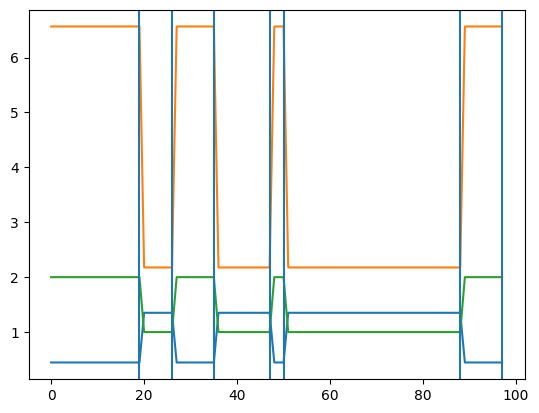

In [ ]:
plt.plot(traj[:,2:5]);
for i in np.flatnonzero(traj[:,-1]): plt.axvline(i);

## STDataset

In [ ]:
#| export
class STDataset(Dataset):
    """Single trajectory-centric data set in which every sample is a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path,
                 bs: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        path = path/'trajectories.npz'
        f = np.load(path[-4]+'_600.npz') if load_600 else np.load(path) # rest of the pipeline not implemented for 600, left for custom batch cutting of variavle length
        self.trajs = f
        num_trajs_len = f['num_trajs_len']  # number of trajectories per length
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        #                                 x,y                         state
        batch = self.trajs[str(l)][buc,:, :2], self.trajs[str(l)][buc,:,4:5]
        return batch

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2")

bs_=100*20
data = STDataset(data_path, bs_, drop_last=False)

dl = DataLoader(data, shuffle=True, )#collate_fn=collate_fn)
# dls = DataLoaders.from_dsets(ds_train, ds_valid,bs=None)

In [ ]:
#| export
# https://github.com/fastai/fastai/blob/master/fastai/data/load.py#L85
class DataLoaderIndexed(DataLoader):
    def __init__(self, idxs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        store_attr()
    def get_idxs(self):
        idxs = self.idxs #Inf.count if self.indexed else Inf.nones
        #if self.n is not None: idxs = list(itertools.islice(idxs, self.n))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs

In [ ]:
dl_ = DataLoaderIndexed(L([2,3,4,5]), data, shuffle=True,)

In [ ]:
#| export
def _get_dls_from_ds(ds, split_pct=0.2, shuffle=True):
    "Returns `DataLoaders` built from `ds`."
    idx = torch.randperm(len(ds)).tolist() if shuffle else list(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_dl = DataLoaderIndexed(idx[cut:],ds, shuffle=shuffle)
    valid_dl = DataLoaderIndexed(idx[:cut],ds, shuffle=False)
    return DataLoaders(train_dl, valid_dl,)

In [ ]:
torch.randperm(8).tolist()

[1, 4, 7, 3, 5, 6, 2, 0]

In [ ]:
dls = _get_dls_from_ds(data)

In [ ]:
torch.sort(torch.tensor(dls[1].get_idxs())), torch.sort(torch.tensor(dls.get_idxs()))

(torch.return_types.sort(
 values=tensor([  2,   9,  10,  11,  18,  22,  25,  26,  31,  38,  45,  47,  48,  54,
          56,  61,  63,  67,  71,  72,  85,  90,  93, 104, 106, 109, 110, 120,
         122, 127, 134, 142, 148, 154, 158, 162, 179, 184, 186, 189, 190, 191,
         192, 194, 203, 205, 212, 216, 217, 219, 220, 226, 229, 234, 239, 244,
         245, 247, 248, 249, 250, 259, 265, 271, 273, 274, 277, 279, 281, 282,
         292, 293, 297, 298, 299, 307, 311, 319, 320, 322, 323, 324, 330, 341,
         344, 351, 356, 359, 362, 367, 381, 385, 386, 388, 390, 395, 422, 425,
         431, 442, 451, 453, 455, 463, 472, 478, 480, 489, 492, 497, 500, 534,
         535, 536, 552, 553, 554, 561, 568, 569, 575, 581, 583, 585, 588, 589,
         599, 611, 621, 624, 635, 641, 642, 644, 649, 652, 657, 664, 665, 681]),
 indices=tensor([ 93,  65, 119,  23, 126, 135,  28,  78,  68,  13,  49, 130,  76, 139,
         117,  10, 131,  26,  62,   3,  41,  34,  75,  74,  80,  15,  30, 120,
         

In [ ]:
dls[1].idxs

[350,
 273,
 473,
 12,
 389,
 339,
 569,
 395,
 19,
 678,
 369,
 547,
 622,
 295,
 258,
 502,
 261,
 393,
 638,
 351,
 564,
 536,
 667,
 201,
 641,
 377,
 456,
 394,
 29,
 436,
 266,
 530,
 451,
 340,
 148,
 681,
 490,
 683,
 392,
 300,
 556,
 230,
 272,
 489,
 2,
 390,
 210,
 24,
 685,
 602,
 290,
 534,
 252,
 380,
 438,
 373,
 190,
 546,
 401,
 222,
 620,
 293,
 35,
 467,
 535,
 435,
 322,
 404,
 136,
 668,
 113,
 653,
 345,
 617,
 149,
 532,
 181,
 700,
 422,
 39,
 381,
 428,
 527,
 513,
 632,
 403,
 431,
 169,
 545,
 500,
 312,
 516,
 509,
 159,
 142,
 457,
 234,
 0,
 3,
 192,
 417,
 78,
 643,
 531,
 398,
 470,
 236,
 661,
 429,
 263,
 115,
 106,
 367,
 479,
 69,
 8,
 195,
 406,
 247,
 378,
 243,
 507,
 391,
 217,
 385,
 326,
 134,
 362,
 568,
 444,
 560,
 15,
 365,
 533,
 80,
 600,
 128,
 324,
 325,
 572]

In [ ]:
dls.one_batch()

(tensor([[[ 98.7184,  24.7489],
          [ 99.1391,  25.7522],
          [ 98.3029,  26.1460],
          ...,
          [ 50.2658,  82.0121],
          [ 49.7881,  81.8704],
          [ 49.4360,  81.4917]],
 
         [[ 32.5814, 120.3634],
          [ 32.4354, 121.4797],
          [ 29.1993, 119.5925],
          ...,
          [ 33.7173, 122.0749],
          [ 34.2768, 121.0772],
          [ 33.4801, 120.5000]],
 
         [[ 19.0762,  78.0677],
          [ 27.2189,  63.3270],
          [ 38.6732,  47.9758],
          ...,
          [ 31.0286,  41.1830],
          [ 31.1575,  40.3273],
          [ 50.6909,  36.5518]],
 
         [[ 83.2558,  91.4372],
          [ 87.2203,  88.8118],
          [ 89.4869,  88.7978],
          ...,
          [111.0424, 186.7243],
          [111.4372, 191.0853],
          [112.4420, 193.6933]],
 
         [[106.3693, 126.1884],
          [107.1391, 126.7510],
          [107.4667, 127.1581],
          ...,
          [187.0018, 187.9876],
          [188.84

In [ ]:
data.trajs['20'].shape

(310, 20, 5)

In [ ]:
data[0][0].shape, data[1][1].shape, data[2][1].shape, data[3][1].shape, data[4][1].shape

((100, 20, 2), (100, 20, 1), (100, 20, 1), (10, 20, 1), (95, 21, 1))

In [ ]:
data.num_trajs_len[:6]

array([310, 265, 283, 248, 232, 201])

In [ ]:
for i in range(15):
    print(-i, data[-i][0].shape, np.prod(data[-i][0].shape[0:2]))

0 (100, 20, 2) 2000
-1 (2, 596, 2) 1192
-2 (3, 596, 2) 1788
-3 (2, 594, 2) 1188
-4 (3, 593, 2) 1779
-5 (2, 592, 2) 1184
-6 (3, 592, 2) 1776
-7 (3, 591, 2) 1773
-8 (2, 590, 2) 1180
-9 (2, 589, 2) 1178
-10 (2, 588, 2) 1176
-11 (2, 587, 2) 1174
-12 (1, 586, 2) 586
-13 (2, 584, 2) 1168
-14 (2, 583, 2) 1166


In [ ]:
# pytorch DataLoader gives another batch dimension next(iter(dl))[0].shape # torch.Size([1, 2, 549, 2])

torch.Size([1, 2, 549, 2])

In [ ]:
dl.one_batch()

(tensor([[[ 14.4615, 195.2686],
          [ 14.3651, 195.7650],
          [ 14.5442, 195.7359],
          ...,
          [ 14.3688, 197.1243],
          [ 14.3841, 196.9323],
          [ 13.9860, 196.6839]]]),
 tensor([[[2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
          [2.],
      

In [ ]:
dl_.one_batch()

(tensor([[[176.0862, 139.3269],
          [165.8671, 130.3234],
          [164.9157, 132.5010],
          ...,
          [185.3315, 137.2085],
          [184.1648, 137.3430],
          [184.8562, 139.6388]],
 
         [[ 82.8390,  63.3102],
          [ 81.7507,  93.7487],
          [100.5053, 118.7521],
          ...,
          [ 83.7678,  45.1418],
          [ 99.1388,  36.5292],
          [ 89.9235,  14.9197]],
 
         [[ 61.6738,  55.7587],
          [ 64.4477,  54.0780],
          [ 67.0706,  54.8753],
          ...,
          [ 68.6801,  92.9531],
          [ 67.7280,  96.2302],
          [ 65.9870,  98.0843]],
 
         ...,
 
         [[181.1712, 149.0661],
          [172.4107, 143.3229],
          [157.0437, 145.0869],
          ...,
          [143.8634, 175.1216],
          [117.0372, 180.9680],
          [102.8589, 185.8194]],
 
         [[181.4679, 184.3875],
          [165.6327, 188.1172],
          [172.7188, 183.5561],
          ...,
          [150.8839,  76.7002],
 

In [ ]:
dl_.get_idxs()

[2, 5, 3, 4]

## Merge curated datasets

In [ ]:
def get_angle(from_vec, # T, d=2
              to_vec,   # T, d=2
              ):
    x1, y1 = from_vec[...,0], from_vec[...,1]
    x2, y2 = to_vec[...,0], to_vec[...,1]
    dot = x1*x2 + y1*y2      # Dot product between [x1, y1] and [x2, y2]
    det = x1*y2 - y1*x2      # Determinant (cross2d) # 2.53 micros, njit 256 ns
    return np.arctan2(det, dot)

# We want a relative description of the trajectory
# the modulus of the displacement Delta r, and the change of angle between successive displacements Delta theta 
def cartesian_to_relative_polar(trajs_cart):
    """
    Converts 2D trajectories in cartesian coordinates to 
    a relative representation of polar coordinates.
    
    Parameters:
    - cartesian_coordinates:
    A numpy array of shape (N, T, 2) where
    N is the number of trajectories,
    T is the number of time steps, and
    2 represents the x and y coordinates.
    
    Returns:
    - An array containing:
    the radius (rho) of each point, and
    the angle from previous direction (theta) of each point in radians.
    """
    # take displacements of the trajectory
    disps_cart = trajs_cart[:, 1:] - trajs_cart[:, :-1]
    # Allocate
    polar_coords = np.zeros_like(disps_cart)
    
    # Calculate the magnitude (rho) of each point
    polar_coords[...,0] = np.hypot(disps_cart[..., 0], disps_cart[..., 1])  #  dr
    
    # Calculate the angle (theta) between segments
    v1,v2 = trajs_cart[:,1:-1]-trajs_cart[:,:-2], trajs_cart[:,2:]-trajs_cart[:,1:-1]
    polar_coords[:,1:,1] = get_angle(v1,v2) # d theta
    
    return polar_coords

In [ ]:
40-18

22

In [ ]:
def merge_curated_ds(data_path):
    trajs = {str(l): [] for l in np.arange(20,600)}
    for i in trange(18,41):#17):
        # append each array to the corresponding length
        f = np.load(data_path/f'medium_{i}'/f"track_{2}"/'trajectories_c.npz')
        for k in L(f.keys())[:-2]:  trajs[k].append(f[k])
    print('Loaded')
    for k,v in tqdm(trajs.items()):    trajs[k] = np.concatenate(v, dtype=np.float32)
    print('Concatenated', f'{trajs['20'].shape=}', f'{trajs['500'].shape=}')
    for k,v in tqdm(trajs.items()):
        t_shape = list(v.shape); t_shape[-1]+=2
        t = np.zeros(t_shape, dtype=np.float32)
        t[:,:,:v.shape[-1]] = v # N', T', 6 (x,y,alpha,D,State,cp)
        t[:,1:,v.shape[-1]:]= cartesian_to_relative_polar(v[:,:,:2]) # N', T'-1, 2 (dr, dtheta)
        np.save(data_path/'big22'/f"track_{2}"/f'trajectories_c_L{k}',t)

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/")

In [ ]:
! mkdir /media/scratrch_data/nanoninjas/data/raw/big22/track_2/

In [ ]:
! ls /media/scratrch_data/nanoninjas/data/raw/

baby	   medium_13  medium_21  medium_3   medium_38  medium_46  public_data
big	   medium_14  medium_22  medium_30  medium_39  medium_47  starting_kit
big22	   medium_15  medium_23  medium_31  medium_4   medium_48  test
challenge  medium_16  medium_24  medium_32  medium_40  medium_49  train
medium_0   medium_17  medium_25  medium_33  medium_41  medium_5
medium_1   medium_18  medium_26  medium_34  medium_42  medium_6
medium_10  medium_19  medium_27  medium_35  medium_43  medium_7
medium_11  medium_2   medium_28  medium_36  medium_44  medium_8
medium_12  medium_20  medium_29  medium_37  medium_45  medium_9


In [ ]:
merge_curated_ds(data_path)

  0%|          | 0/23 [00:00<?, ?it/s]

Loaded


  0%|          | 0/580 [00:00<?, ?it/s]

Concatenated trajs['20'].shape=(38424, 20, 6) trajs['500'].shape=(4431, 500, 6)


  0%|          | 0/580 [00:00<?, ?it/s]

In [ ]:
!ls -alh $data_path/'big/track_2/'

total 50G
drwxrwx--- 2 gfernandez Domain Users  36K jul  9 18:36 .
drwxrwx--- 3 gfernandez Domain Users 4,0K jul  9 16:38 ..
-rw-rw---- 1 gfernandez Domain Users 111M jul  9 18:32 trajectories_c_L100.npy
-rw-rw---- 1 gfernandez Domain Users 110M jul  9 18:32 trajectories_c_L101.npy
-rw-rw---- 1 gfernandez Domain Users 111M jul  9 18:32 trajectories_c_L102.npy
-rw-rw---- 1 gfernandez Domain Users 111M jul  9 18:32 trajectories_c_L103.npy
-rw-rw---- 1 gfernandez Domain Users 110M jul  9 18:32 trajectories_c_L104.npy
-rw-rw---- 1 gfernandez Domain Users 111M jul  9 18:32 trajectories_c_L105.npy
-rw-rw---- 1 gfernandez Domain Users 110M jul  9 18:32 trajectories_c_L106.npy
-rw-rw---- 1 gfernandez Domain Users 109M jul  9 18:32 trajectories_c_L107.npy
-rw-rw---- 1 gfernandez Domain Users 109M jul  9 18:32 trajectories_c_L108.npy
-rw-rw---- 1 gfernandez Domain Users 111M jul  9 18:32 trajectories_c_L109.npy
-rw-rw---- 1 gfernandez Domain Users 111M jul  9 18:32 trajectories_c_L110.npy
-rw-rw

In [ ]:
a = np.load(data_path/'big22'/f"track_{2}"/f'trajectories_c_L{20}.npy')

In [ ]:
np.all(np.isfinite(a))

True

In [ ]:
a.shape

(38424, 20, 8)

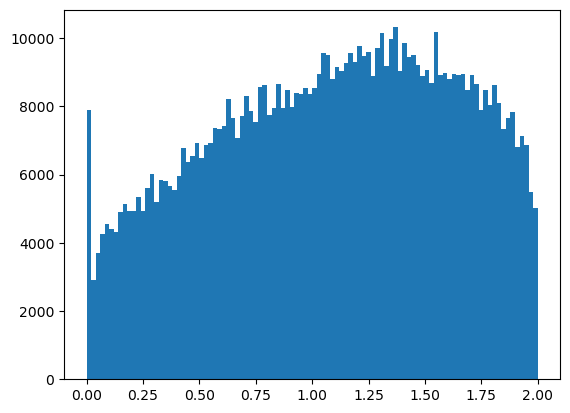

In [ ]:
plt.hist(a[:,:,2].reshape(-1),100);

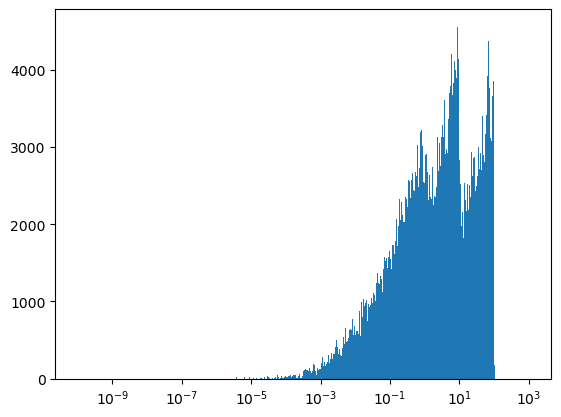

In [ ]:
plt.hist(a[:,:,3].reshape(-1),np.geomspace(1e-10,1e3,1000));plt.xscale('log')

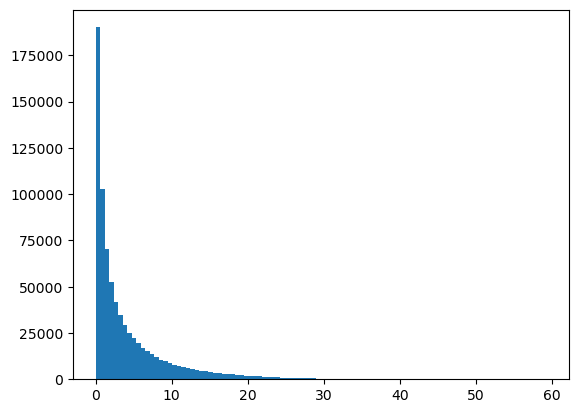

In [ ]:
plt.hist(a[:,:,-2].reshape(-1),100);

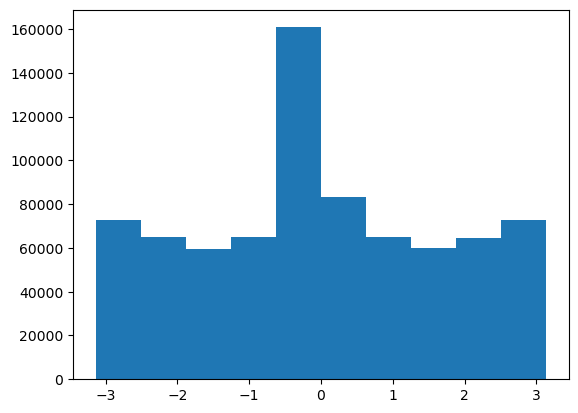

In [ ]:
plt.hist(a[:,:,-1].reshape(-1));

## Big dataset dataloader

In [ ]:
# will be imported from lib ---------------------------------------------
from fastai.vision.all import *
from torch.utils.data import Dataset
#| export
class STBigDataset(Dataset):
    """Single trajectory-centric data set in which every sample is a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path, # data_path/f'big'/f"track_{2}"/f'trajectories_c_L{k}'
                 bs: int,
                 target: int,
                 drop_last: bool=False,
                 use_memmap: bool=True,
                ):
        self.target = target
        lengths = np.arange(20,600)
        self.lengths = lengths
        trajs = {str(l):np.load(path/f'trajectories_c_L{l}', memmap=use_memmap) for l in lengths}
        self.trajs = trajs
        # number of trajectories per length
        num_trajs_len = np.array([v.shape[0] for v in trajs.values()])
        self.num_trajs_len = num_trajs_len  # debug
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                       for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                       for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum)
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state, dr,dtheta
        # x = self.trajs[str(l)][buc,:, :2]  # x, y
        # x = cartesian_to_relative_polar(x) # dr, dtheta
        x = self.trajs[str(l)][buc,:, -2:]  # dr, dtheta
        if self.target==0:
            #y = self.trajs[str(l)][buc,:, 2:3] # alpha
            y = self.trajs[str(l)][buc,1:, 2:3] # alpha [1:]
        if self.target==1:
            y = self.trajs[str(l)][buc,1:, 3:4]
            # for old STEP comment the following
            x[...,0] = np.log10(x[...,0]) # log10 dr
            y = np.log10(np.maximum(y,1e-10)) # log10 D [1:]
        if self.target==2: #                     state
            y = self.trajs[str(l)][buc,:,4:5].astype(int)
        if self.target==3: #                                                               cps
            y = self.trajs[str(l)][buc,:,5:6].astype(int)
            y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        return x,y #batch

class STPDataset(Dataset):
    """Single trajectory predictions-centric data set in which every sample is a prediction of a single trajectory.
       Made with performance in mind for in-memory (mmap otherwise) datasets with bucketing.
    """
    # load the file in memory and slice it for batches.
    # Defining batch_size_=B*T as a constant, we make batches for each index.
    # For instance, idx=0 corresponds to T=20 so take B trajs from array of lengths=20 such that B*T==batch_size_
    # idx=1 takes the next bucket from T=20 array
    # so we need to map idx to length-mini-batch pair:
    # from known number of arrays with length T and bs create an indexable of pairs(length, slice)
    # to load that contiguous part
    def __init__(self, path_x, path_y,
                 bs: int,
                 drop_last: bool=False,
                 load_600: bool=False,
                ):
        #path = path/'trajectories.npz'
        self.x = np.load(path_x)
        f = np.load(path_y[-4]+'_600.npz') if load_600 else np.load(path_y)
        # rest of the pipeline not implemented for 600, left for custom batch cutting of variable length
        self.trajs = f
        # number of trajectories per length
        num_trajs_len = f['num_trajs_len'] # if hasattr(f, 'num_trajs_len') else np.array([v.shape[0] for v in L(f.values())[:-2]])
        self.num_trajs_len = num_trajs_len  # debug    
        lengths = f['lengths']  # 20,21...599
        self.lengths = lengths
        size_trajs_len = num_trajs_len * lengths  # size = num_trajs*T
        
        # how many buckets of size bs are on each length
        num_buc = size_trajs_len/bs
        if drop_last:
            num_buc = np.floor (num_buc).astype(int)
        else:  # take also incomplete buckets, not empty ones
            num_buc = np.ceil  (num_buc).astype(int)
        num_buc_cum = np.cumsum(num_buc)
        self.num_buc_cum = num_buc_cum
        
        # bucket lengths: how many N trajs of length T are on each length
        bucs_len = (bs / lengths).astype(int)
        # or equally distributed bucs per length bucs_len = num_trajs_len/num_buc
        self.bucs_len = bucs_len # debug
        
        # create bucket slices
        self.bucs = L([slice(i*blen,min((i+1)*blen, trajs_L))
                     for blen,n_buc,trajs_L in zip(bucs_len,num_buc, num_trajs_len)
                     for i in range(n_buc)])
        self.size = len(self.bucs)

    def __len__(self):
        "Return the number of batches in the dataset"
        return self.size
        
    def idx2lenbuc(self, idx):
        # length from index for desired bs
        l = np.digitize(idx, self.num_buc_cum) 
    
        # compute here every time
        # num_buc_cum_0 = np.concatenate((self.num_buc_cum,[0]))
        # b_idx = idx-num_buc_cum_0[l-1]
        
        # buc = slice(b_idx*self.bucs_len[l],min((b_idx+1)*self.bucs_len[l],self.num_trajs_len[l]))
        # assert buc==self.bucs[idx], f'{idx=} {num_buc_cum_0[l-1]=} {b_idx=} {buc=} {self.bucs[idx]=}'
        
        # or take precomputed ---------v
        return self.lengths[l], self.bucs[idx]
    
    def __getitem__(self, idx):
        if idx<0: idx= self.size+idx-1
        l, buc = self.idx2lenbuc(idx)
        # finally, slice and split into inputs and targets: xb, yb
        # trajs = {'20':ndarray(N', T=20,F)}, F=x,y,alpha,D,state
        #                                 x,y                         state
        #batch = self.trajs[str(l)][buc,:, :2], self.trajs[str(l)][buc,:,4:5].astype(int)
        #                                                               cps
        y = self.trajs[str(l)][buc,:,5:6].astype(int)
        y[:,-1] = 0 # erase last (in time dimension) cp indicating sequence length
        #             preds: alpha,log10D; target: cps
        batch = self.x[str(l)][buc,:, :2], y
        return batch
#| export
#https://github.com/fastai/fastai/blob/master/fastai/data/load.py#L85
class DataLoaderIndexed(DataLoader):
    def __init__(self, idxs, *args, **kwargs):
        super().__init__(*args, **kwargs)
        store_attr()
    def get_idxs(self):
        idxs = self.idxs #Inf.count if self.indexed else Inf.nones
        #if self.n is not None: idxs = list(itertools.islice(idxs, self.n))
        if self.shuffle: idxs = self.shuffle_fn(idxs)
        return idxs
#| export
def _get_dls_from_ds(ds, split_pct=0.2, shuffle=True):
    "Returns `DataLoaders` built from `ds`."
    idx = torch.randperm(len(ds)).tolist() if shuffle else list(range(len(ds)))
    cut = int(len(ds)*split_pct)
    train_dl = DataLoaderIndexed(L(idx[cut:]),ds, shuffle=shuffle) # pin_memory=True
    # train_dl.idxs = L(idx[cut:])
    # TODO DataLoaderIndexed without ?? No, It will fail the purpose when fastai creates a new dl for get_preds
    valid_dl = DataLoaderIndexed(L(idx[:cut]),ds, shuffle=False)
    return DataLoaders(train_dl, valid_dl,)
#------------------------------------------------------------------------------
def get_dls_array(data_path, bs_: int, target: int, drop_last: bool=False):
    return _get_dls_from_ds(STDataset(data_path, bs_, target, drop_last=drop_last))
def get_dls_array_preds(preds_path, data_path, bs_, drop_last: bool=False):
    return _get_dls_from_ds(STPDataset(preds_path, data_path, bs_, drop_last=drop_last))

# Transforms

Data augmentation transforms for FOVs.

In [ ]:
#| export

class SampleTrajectories:
    """Randomly sample trajectories from every FOV."""

    def __init__(self, sampler):
        self.sampler = sampler

    def __call__(self, fov, labels):
        n_trajs = self.sampler.sample()
        idx = np.random.permutation(np.arange(len(fov)))
        new_trajs, new_labels = [], []
        
        for i in idx[:n_trajs]:
            new_trajs.append(fov[i])
            if labels:
                new_labels.append(labels[i])

        return new_trajs, new_labels


class Sampler:
    "Sampler base class."

    def sample(self):
        raise NotImplementedError(f"Implement an appropriate sample method for {self.__class__.__name__}")


class FixedSampler(Sampler):
    "Return a constant value. Mostly intended for debugging and testing."

    def __init__(self, value):
        self.value = value

    def sample(self):
        return self.value


class GaussianSampler(Sampler):
    "Return values according to a Gaussian distribution with a fixed mean and std."

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def sample(self):
        return np.round(np.random.randn() * self.std + self.mean).astype(int)


class UniformSampler(Sampler):
    "Return uniformly distributed samples between low and high values."

    def __init__(self, low, high):
        self.low = low
        self.high = high

    def sample(self):
        return np.random.randint(self.low, self.high)

In [ ]:
data_path = Path("/media/scratrch_data/nanoninjas/data/raw/baby/track_2")

In [ ]:
sampler = FixedSampler(7)
transforms = [SampleTrajectories(sampler)]
data = FOVDataset(data_path, transforms=transforms)
dl = data.to_dl(batch_size=3, shuffle=False)

In [ ]:
x, y = next(iter(dl))
[len(fov) for fov in x]

[7, 7, 7]

In [ ]:
sampler = UniformSampler(10, 20)
transforms = [SampleTrajectories(sampler)]
data = FOVDataset(data_path, transforms=transforms)
dl = data.to_dl(batch_size=3, shuffle=False)

In [ ]:
x, y = next(iter(dl))
[len(fov) for fov in x]

[13, 12, 14]

In [ ]:
sampler = GaussianSampler(50, 10)
transforms = [SampleTrajectories(sampler)]
data = FOVDataset(data_path, transforms=transforms)
dl = data.to_dl(batch_size=3, shuffle=False)

In [ ]:
x, y = next(iter(dl))
[len(fov) for fov in x]

[54, 33, 39]

In [ ]:
# The public data has a distribution similar to this one
data = np.random.randn(1000) * 10 + 50

(array([  2.,  11.,  50., 105., 200., 247., 224., 109.,  41.,  11.]),
 array([14.20768806, 20.69658033, 27.18547259, 33.67436486, 40.16325712,
        46.65214939, 53.14104165, 59.62993391, 66.11882618, 72.60771844,
        79.09661071]),
 <BarContainer object of 10 artists>)

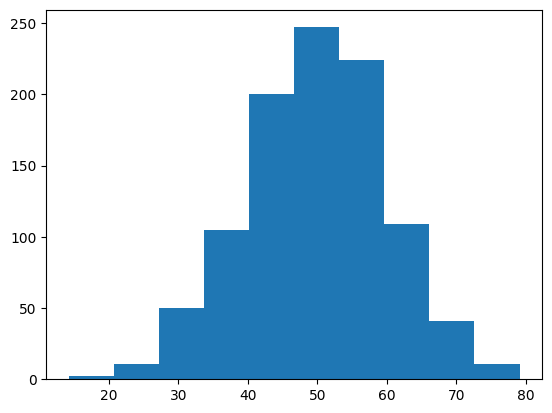

In [ ]:
plt.hist(data)